In [2]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os

# Scouting Analysis

This notebook offers a scouting analysis tool for new player acquisitions using financial data from Transfermarkt and player statistics from Wyscout.

- Financial data from Transfermarkt: Transfer fees, market value
- Player statistics from Wyscout: Player position, age, minutes played, goals, assists, shots, passes, tackles, interceptions, etc.

# 1. Data Collection

## 1.1. Transfermarkt

In [4]:
def to_number(string):
    """Converts a string to a number, e.g. "€1.2m" to 1.2"""
    try:
        if string[-1] == "m":
            # convert to millions
            return float(string[1:-1])
        else:
            return float(string[1:-1]) / 1000
    except:
        return np.nan


# Get out Player Name, Position, Left Club, Joined Club, Fee
player_names = []
player_fees = []
player_values = []
player_positions = []

headers = {"User-Agent": 
           "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36"}

base_url = "https://www.transfermarkt.co.uk/transfers/transferrekorde/statistik?saison_id=2017&land_id=0&ausrichtung=&spielerposition_id=&altersklasse=&leihe=&w_s=&plus=1&page="

# Loop through multiple pages
page_number = 1
end = False
limit = 150

while end == False:
    page = base_url + str(page_number)
    try:
        pt = requests.get(page, headers=headers)

        ps = BeautifulSoup(pt.content, "html.parser")

        player_rows = ps.find_all("tr", {"class": ["odd", "even"]})
        page_number += 1

        for player_row in player_rows:
            player_name = player_row.select("a")[0].text
            player_fee = to_number(player_row.select("td")[17].text)
            player_value = to_number(player_row.select("td")[6].text)
            player_position = player_row.select("td")[4].text
            
            player_names.append(player_name)
            player_fees.append(player_fee)
            player_values.append(player_value)
            player_positions.append(player_position)
    
        if limit is not None:
            if page_number == limit:
                end = True
                print("End of pages", page_number)

    except Exception as e:
        print(e)
        end = True
        print("End of pages", page_number)

df_players_finance = pd.DataFrame({
    "Player Name": player_names,
    "Market Value (m€)": player_values,
    "Fee (m€)": player_fees,
    "Position": player_positions
})

df_players_finance

os.makedirs("data", exist_ok=True)
df_players_finance.to_csv("data/players_finance.csv", index=False)

End of pages 150


In [6]:
df_players_finance.head()

,Player Name,Market Value (m€),Fee (m€),Position
0,Neymar,100.0,222.00,Left Winger
1,Philippe Coutinho,90.0,135.00,Attacking Midfield
2,Ousmane Dembélé,33.0,135.00,Right Winger
3,Romelu Lukaku,50.0,84.70,Centre-Forward
4,Virgil van Dijk,30.0,84.65,Centre-Back


## 1.2 Wyscout Player data

Please check that the wyscount data is downloaded and sits in /src/wyscout directory in this repository!

In [7]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
wyscout_dir = os.path.join(parent_dir, "src", "wyscout")

# Check if dir exists
assert os.path.exists(wyscout_dir), "Wyscout directory does not exist, download data!"

We define the function that caluclates the metrics with the given data files

In [8]:
import pandas as pd
import json
import os
import pathlib
import numpy as np
from scipy import stats

def decode_unicode_escapes(name):
    try:
        return name.encode("utf-8").decode("unicode_escape")
    except Exception as e:
        return name

def calculate_player_stats(players_file_path, Country):
    """
    Calculates performance metrics for football players from event data.

    Returns:
    DataFrame containing player IDs, names, and calculated statistics.
    """
    
    event_file_path = os.path.join(wyscout_dir, "events" , f"events_{Country}.json")

    # Load event data
    with open(event_file_path) as file:
        events_data = json.load(file)
    events_df = pd.DataFrame(events_data)

    # Load player data
    with open(players_file_path) as file:
        players_data = json.load(file)
    players_df = pd.DataFrame(players_data)

    # TURNOVERS
    def turnovers(df):
        dribble_forward = df.loc[df["subEventName"] == "Ground attacking duel"]
        lost_dribble_forward = dribble_forward.loc[dribble_forward.apply(lambda x:{"id":701} in x.tags, axis = 1)]
        ldf = lost_dribble_forward.groupby(["playerId"]).eventId.count().reset_index()
        ldf.rename(columns = {"eventId":"lost_dribble_forward"}, inplace=True)
        
        passes = df.loc[df["eventName"] == "Pass"]
        lost_pass = passes.loc[passes.apply(lambda x:{"id":1802} in x.tags, axis = 1)]
        lp = lost_pass.groupby(["playerId"]).eventId.count().reset_index()
        lp.rename(columns = {"eventId":"lost_pass"}, inplace=True)

        turnovers_made = ldf.merge(lp, how = "outer", on = ["playerId"])
        return turnovers_made

    # CLEARANCES
    def clearance(df):
        clearance = df.loc[df["subEventName"] == "Clearance"]
        clearing_player = clearance.groupby(["playerId"]).eventId.count().reset_index()
        clearing_player.rename(columns = {"eventId":"clearances"}, inplace=True)
        return clearing_player

    # INTERCEPTIONS
    def interception(df):
        opp_pass = df.loc[df["eventName"] == "Pass"]
        interception = opp_pass.loc[opp_pass.apply(lambda x:{"id":1401} in x.tags, axis = 1)]
        intercepting_player = interception.groupby(["playerId"]).eventId.count().reset_index()
        intercepting_player.rename(columns = {"eventId":"interceptions"}, inplace=True)
        return intercepting_player

    # DUELS WON
    def defensiveDuelsWon(df):
        loose_duels = df.loc[df["subEventName"] == "Ground loose ball duel"]
        won_loose_duels = loose_duels.loc[loose_duels.apply(lambda x:{"id":703} in x.tags, axis = 1)]
        wld_player = won_loose_duels.groupby(["playerId"]).eventId.count().reset_index()
        wld_player.rename(columns = {"eventId":"loose_duels_won"}, inplace=True)
        
        def_ground_duels = df.loc[df["subEventName"].isin(["Ground defending duel"])]
        won_ground_duels = def_ground_duels.loc[def_ground_duels.apply(lambda x:{"id":703} in x.tags, axis = 1)]
        wgd_player = won_ground_duels.groupby(["playerId"]).eventId.count().reset_index()
        wgd_player.rename(columns = {"eventId":"def_ground_duels_won"}, inplace=True)

        air_duels = df.loc[df["subEventName"].isin(["Air duel"])]
        won_air_duels = air_duels.loc[air_duels.apply(lambda x:{"id":703} in x.tags, axis = 1)]
        wad_player = won_air_duels.groupby(["playerId"]).eventId.count().reset_index()
        wad_player.rename(columns = {"eventId":"air_duels_won"}, inplace=True)
        
        duels_won = wgd_player.merge(wld_player, how = "outer", on = ["playerId"]).merge(wad_player, how = "outer", on = ["playerId"])
        return duels_won

    # Apply functions
    turnover_stats = turnovers(events_df)
    clearance_stats = clearance(events_df)
    interception_stats = interception(events_df)
    duels_stats = defensiveDuelsWon(events_df)

    # Merge all statistics into a single DataFrame
    stats_df = pd.DataFrame(events_df["playerId"].unique(), columns=["playerId"])
    for stat_df in [turnover_stats, clearance_stats, interception_stats, duels_stats]:
        stats_df = stats_df.merge(stat_df, how="left", on=["playerId"])

    # Merge with player minutes played
    # path_minutes = os.path.join(str(pathlib.Path().resolve().parents[0]), "DM-Football", "src", "wyscout", "minutes_played", "minutes_played_per_game_England.json") 
    path_minutes = os.path.join(wyscout_dir, "minutes_played" , f"minutes_played_per_game_{Country}.json")
    
    with open(path_minutes) as f:
        minutes_per_game = json.load(f)
    minutes_df = pd.DataFrame(minutes_per_game)
    minutes = minutes_df.groupby(["playerId"]).minutesPlayed.sum().reset_index()

    stats_df = stats_df.merge(minutes, how="left", on=["playerId"])
    stats_df = stats_df.fillna(0)
    stats_df = stats_df.loc[stats_df["minutesPlayed"] > 400]

    # Calculate per 90 statistics
    for column in ["lost_dribble_forward", "lost_pass", "clearances", "interceptions", "loose_duels_won", "def_ground_duels_won", "air_duels_won"]:
        stats_df[column + "_per90"] = stats_df.apply(lambda x: (x[column]*90)/x["minutesPlayed"] if x["minutesPlayed"] > 0 else 0, axis=1)

    # Merge with player names
    players_df["fullName"] = players_df["firstName"].fillna("") + " " + players_df["middleName"].fillna("") + " " + players_df["lastName"].fillna("")
    
    players_df["fullName"] = players_df["fullName"].str.strip().apply(decode_unicode_escapes)

    players_df = players_df[["wyId", "fullName"]]
    players_df.rename(columns={"wyId": "playerId"}, inplace=True)
    final_df = stats_df.merge(players_df, how="left", on="playerId")

    features = {
        "playerId": "Player_Id",
        "fullName": "Full_Name",
        "air_duels_won_per90": "Air_Duels_Won",
        "interceptions_per90": "Interceptions",
        "clearances_per90": "Clearances",
        "lost_pass_per90": "Turnovers",
        "loose_duels_won_per90": "Loose_Ball_Duels_Won",
        "def_ground_duels_won_per90": "Defensive_Duels_Won"
    }

    final_df = final_df[list(features.keys())]
    final_df.rename(columns=features, inplace=True)
    final_df.set_index("Player_Id", inplace=True)

    return final_df

Next step, we iterate over all countries and caclulcate player statstics. Outcome will be one big data file

In [97]:
player_stats_df = pd.DataFrame()

countries = ["England", "France", "Germany", "Italy", "Spain"]

players_file_path = os.path.join(wyscout_dir, "player.json")
events_dir = os.path.join(wyscout_dir, "events")


for country in countries:
        print("Processing", country)
        country_stats_df = calculate_player_stats(players_file_path, country)
        player_stats_df = pd.concat([player_stats_df, country_stats_df]).drop_duplicates()

Processing England
Processing France
Processing Germany
Processing Italy
Processing Spain


In [101]:
# Save to filesytem
os.makedirs("data", exist_ok=True)
player_stats_df.to_csv("data/player_stats.csv")

In [106]:
player_stats_df

,Full_Name,Air_Duels_Won,Interceptions,Clearances,Turnovers,Loose_Ball_Duels_Won,Defensive_Duels_Won
Player_Id,,,,,,,
25413,Alexandre Lacazette,0.947784,0.197455,0.157964,5.410268,1.184730,0.947784
370224,Rob Holding,2.812500,3.437500,2.604167,7.500000,2.291667,1.979167
3319,Mesut Özil,0.000000,0.599201,0.159787,9.027963,0.599201,0.719041
120339,Mohamed Naser Elsayed Elneny,0.800890,2.302558,0.901001,5.305895,0.901001,1.401557
167145,Héctor Bellerín Moruno,1.159284,1.837889,1.244109,8.058435,1.300660,1.131008
...,...,...,...,...,...,...,...
20410,Sulley Ali Muntari,2.846715,3.065693,1.313869,9.416058,1.751825,1.532847
4014,Pedro León Sánchez Gil,1.301653,1.301653,0.836777,9.669421,1.115702,0.278926
3994,Miguel Ángel Moyà Rumbo,0.227848,0.797468,1.025316,2.620253,0.000000,0.000000


# 3. Step, merging financial data with calcuilates metrics

We Will use Levensthein distance to get the similiarty of names and then match by most probable

In [9]:
# Prepare data
players_finance_df = pd.read_csv("data/players_finance.csv")
print(players_finance_df.head())

player_stats_df = pd.read_csv("data/player_stats.csv")
print(player_stats_df.head())

         Player Name  Market Value (m€)  Fee (m€)            Position
0             Neymar              100.0    222.00         Left Winger
1  Philippe Coutinho               90.0    135.00  Attacking Midfield
2    Ousmane Dembélé               33.0    135.00        Right Winger
3      Romelu Lukaku               50.0     84.70      Centre-Forward
4    Virgil van Dijk               30.0     84.65         Centre-Back
   Player_Id                      Full_Name  Air_Duels_Won  Interceptions  \
0      25413           Alexandre  Lacazette       0.947784       0.197455   
1     370224                   Rob  Holding       2.812500       3.437500   
2       3319                    Mesut  Özil       0.000000       0.599201   
3     120339  Mohamed Naser  Elsayed Elneny       0.800890       2.302558   
4     167145        Héctor  Bellerín Moruno       1.159284       1.837889   

   Clearances  Turnovers  Loose_Ball_Duels_Won  Defensive_Duels_Won  
0    0.157964   5.410268              1.184730 

In [18]:
# Used to match names
from difflib import SequenceMatcher

def match_name_with_score(name, list_names, min_score=0.8):
    """
    Returns the best match from a list of names based on similarity score, 
    along with the similarity score.
    """
    best_match = None
    highest_score = 0

    # find match with highest sim
    for candidate in list_names:
        score = SequenceMatcher(None, name, candidate).ratio()
        # set new best match if score is higher
        if score > highest_score and score >= min_score:
            highest_score = score
            best_match = candidate

    # Return score and mathces
    return best_match, highest_score

# Remove duplicates
player_stats_df = player_stats_df.drop_duplicates(subset="Full_Name")
players_finance_df = players_finance_df.drop_duplicates(subset="Player Name")

# Create a mapping of player names to player IDs
name_to_id = dict(zip(player_stats_df["Full_Name"],
                      player_stats_df["Player_Id"]))

# Apply the modified matching function
players_finance_df[["Matched_Name", "Similarity_Score"]] = players_finance_df["Player Name"].apply(
    lambda x: pd.Series(match_name_with_score(x, name_to_id.keys()))
)
players_finance_df["Player_Id"] = players_finance_df["Matched_Name"].map(name_to_id)

# Merge the datasets on Player_Id
combined_df = pd.merge(players_finance_df, player_stats_df, on="Player_Id", how="left")

print("Amount financiaL:", len(players_finance_df))
print("Amount stats:", len(player_stats_df))
print("Amount combined:", len(combined_df))

Amount financiaL: 249
Amount stats: 2007
Amount combined: 249


C:\Users\Philipp\AppData\Local\Temp\ipykernel_16520\2833659335.py:32: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  players_finance_df[['Matched_Name', 'Similarity_Score']] = players_finance_df['Player Name'].apply(


In [19]:
# save to disk
combined_df.to_csv("data/financial_and_stats.csv", index=False)

In [43]:
# drop columns Matched_Name and Similarity_Score
combined_df = pd.read_csv("data/financial_and_stats.csv")
# filter rows containing any NaN values
combined_df = combined_df.dropna()

In [23]:
combined_df.dropna().sort_values(by="Similarity_Score", ascending=False).head(5)

,Player Name,Market Value (m€),Fee (m€),Position,Matched_Name,Similarity_Score,Player_Id,Full_Name,Air_Duels_Won,Interceptions,Clearances,Turnovers,Loose_Ball_Duels_Won,Defensive_Duels_Won
7,Pierre-Emerick Aubameyang,65.0,63.75,Centre-Forward,Pierre-Emerick Aubameyang,0.980392,25867.0,Pierre-Emerick Aubameyang,0.737705,0.819672,0.491803,7.295082,0.983607,0.491803
24,Alex Oxlade-Chamberlain,22.0,38.00,Central Midfield,Alex Oxlade-Chamberlain,0.978723,7868.0,Alex Oxlade-Chamberlain,0.743392,1.090308,0.594714,8.226872,1.635463,1.189427
114,Konstantinos Mitroglou,12.0,15.00,Centre-Forward,Konstantinos Mitroglou,0.977778,93331.0,Konstantinos Mitroglou,2.557377,0.098361,0.196721,2.852459,0.786885,0.196721
19,Federico Bernardeschi,30.0,40.00,Right Winger,Federico Bernardeschi,0.976744,246061.0,Federico Bernardeschi,0.308219,0.308219,1.232877,5.136986,1.438356,1.335616
186,Allan Saint-Maximin,3.0,10.00,Left Winger,Allan Saint-Maximin,0.974359,276211.0,Allan Saint-Maximin,0.423983,0.501071,0.077088,8.248394,0.616702,0.462527


# Step 4. Analysis

In [31]:
# drop nan rows
combined_df = combined_df.dropna()

labels = ["<5", "5-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", ">70"]

# Put the market value into nins
combined_df["Market_Value_Bin"] = pd.cut(
    combined_df["Market Value (m€)"],
    bins=[0, 5, 10, 20, 30, 40, 50, 60, 70, 80],
    labels=labels
)
 
# Fit clustering model on the market value with corresponadnce to bins
kmeans = KMeans(n_clusters=9, random_state=0).fit(combined_df[["Market Value (m€)"]])

C:\Users\Philipp\AppData\Local\Temp\ipykernel_16520\958271422.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Market_Value_Bin'] = pd.cut(
c:\Users\Philipp\miniforge3\envs\mgeneral\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Philipp\miniforge3\envs\mgeneral\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [ ]:
# Cluster the player statistics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale the data
scaler = StandardScaler()

# Select the columns to scale
cols_to_scale = [
    "Air_Duels_Won", "Interceptions", "Clearances", 
    "Turnovers", "Loose_Ball_Duels_Won", "Defensive_Duels_Won"
]

# Scale the columns
combined_df[cols_to_scale] = scaler.fit_transform(combined_df[cols_to_scale])

# Perform clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(combined_df[cols_to_scale])

# Add the cluster labels to the dataframe
combined_df["Cluster"] = kmeans.labels_

C:\Users\Philipp\AppData\Local\Temp\ipykernel_16520\2081270414.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['PCA_1'] = pca_features[:,0]
C:\Users\Philipp\AppData\Local\Temp\ipykernel_16520\2081270414.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['PCA_2'] = pca_features[:,1]
c:\Users\Philipp\miniforge3\envs\mgeneral\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype,

<Axes: xlabel='PCA_1', ylabel='PCA_2'>

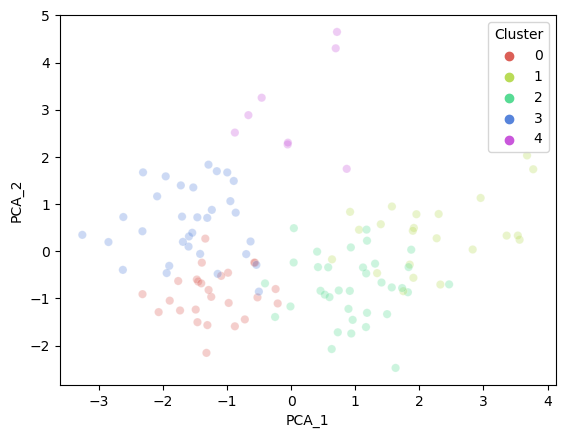

In [33]:
# PCA THE Data to visualise the clusters
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(combined_df[cols_to_scale])

# Transform the data
pca_features = pca.transform(combined_df[cols_to_scale])

# Add the PCA features to the dataframe

combined_df["PCA_1"] = pca_features[:,0]
combined_df["PCA_2"] = pca_features[:,1]

# Plot the clusters
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(
    x="PCA_1", y="PCA_2",
    hue="Cluster",
    palette=sns.color_palette("hls", 5),
    data=combined_df,
    legend="full",
    alpha=0.3
)

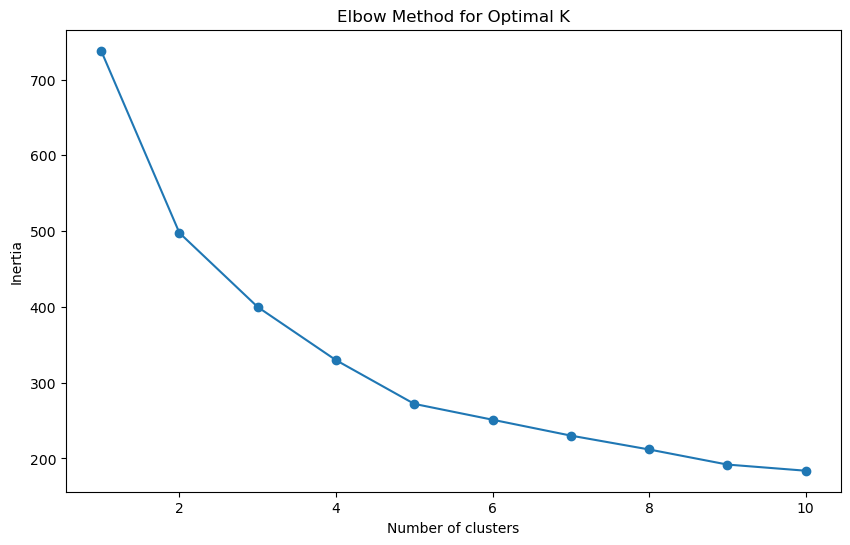

In [37]:
import warnings
warnings.filterwarnings("ignore")

# Selecting the performance-related features for clustering
performance_features = combined_df[["Air_Duels_Won", "Interceptions", "Clearances", "Turnovers", "Loose_Ball_Duels_Won", "Defensive_Duels_Won"]]

# Standardizing the data
scaler = StandardScaler()
performance_scaled = scaler.fit_transform(performance_features)

# Finding the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(performance_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker="o")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

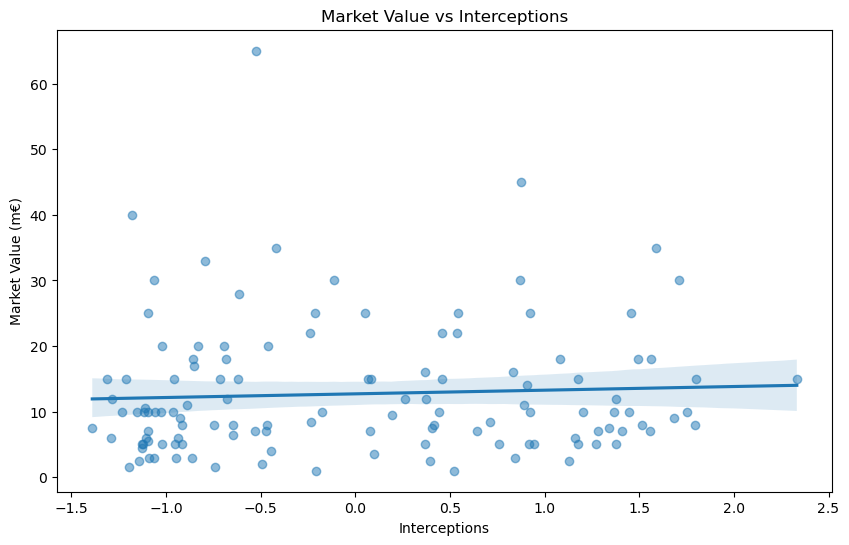

In [40]:
# Creating a scatter plot for interceptions vs market value
plt.figure(figsize=(10, 6))
sns.regplot(x="Interceptions", y="Market Value (m€)", data=combined_df, fit_reg=True, scatter_kws={"alpha":0.5})
plt.title("Market Value vs Interceptions")
plt.xlabel("Interceptions")
plt.ylabel("Market Value (m€)")
plt.show()


In [47]:
combined_df["Position"].unique()

# Defender positions in dataset
defender_pos = ["Centre-Back", "Left-Back", "Right-Back", "Defensive Midfield"]

In [49]:
# filter certain positions
df_defender = combined_df[combined_df["Position"].isin(defender_pos)]

import plotly.express as px

fig = px.scatter(df_defender, x="Interceptions", y="Market Value (m€)", 
                 hover_data=["Player Name"], 
                 trendline="ols",  # Ordinary Least Squares regression
                 title="Interactive Scatter Plot with Regression Line: Market Value vs Interceptions",
                 labels={"Interceptions": "Interceptions", "Market Value (m€)": "Market Value (Million €)"})

fig.show()